# Establish Need for Improvement over Baselines.

## Q1: Given heterogeneous behaviors as input, how does the homogeneous embedding model from Mattson and Brown [2] embed these behaviors?

In [1]:
"""
Externals
"""
import torch
import numpy as np
from novel_swarms.results.results import main as base_results
from novel_swarms.config.defaults import ConfigurationDefaults
from novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from data.swarmset import SwarmDataset
from src.networks.network_wrapper import NetworkWrapper
from src.training.labels import LabelSet
from src.constants import SINGLE_SENSOR_WORLD_CONFIG, TWO_SENSOR_WORLD_CONFIG
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

"""
Import Pretrained Model
"""
arch = NoveltyArchive()
network = NetworkWrapper(output_size=5, margin=1.0, new_model=True)
network.load_from_path("../../../checkpoints/ensembles/01-27-23-BLH-HIL-G/0.pt")
network.eval_mode()

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
Adjusting learning rate of group 0 to 1.0000e-05.


In [2]:
"""
Load Data
"""
homogeneous_dataset = SwarmDataset("../../../data/validation-easy-model", rank=0)
heterogeneous_dataset = SwarmDataset("../../../data/mrs-q1-samples", rank=0)
labels = LabelSet("../../../data/oracle/validation-data-baseline.txt")

In [3]:
"""
Embed
"""
homogeneous_archive = NoveltyArchive()
for i in range(len(homogeneous_dataset)):
    image, controller = homogeneous_dataset[i][0], homogeneous_dataset[i][1]
    image = np.expand_dims(image, axis=0)
    embed = network.batch_out(image)
    embed = embed.detach().cpu().squeeze(dim=0).numpy()
    homogeneous_archive.addToArchive(embed, controller)

heterogeneous_archive = NoveltyArchive()
for i in range(7):
    image, controller = heterogeneous_dataset[i][0], heterogeneous_dataset[i][1]
    image = np.expand_dims(image, axis=0)
    embed = network.batch_out(image)
    embed = embed.detach().cpu().squeeze(dim=0).numpy()
    heterogeneous_archive.addToArchive(embed, controller)

classes = ["Random", "Cyclic", "Milling", "Aggregation", "Dispersal", "Wall-F"]
print(labels.color_map)
labels.set_color(0, (0.8, 0.8, 0.8))

homogeneous_colors = labels.get_colors()
heterogeneous_colors = [(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
homogeneous_labels = [classes[i] for i in labels.get_labels()]

print(homogeneous_archive.archive.shape, heterogeneous_archive.archive.shape)

embeddings = np.concatenate((homogeneous_archive.archive, heterogeneous_archive.archive))
colors = homogeneous_colors + heterogeneous_colors

{0: (1.0, 0.7019607843137254, 0.0), 1: (0.5019607843137255, 0.24313725490196078, 0.4588235294117647), 2: (1.0, 0.40784313725490196, 0.0), 3: (0.6509803921568628, 0.7411764705882353, 0.8431372549019608), 4: (0.7568627450980392, 0.0, 0.12549019607843137), 5: (0.807843137254902, 0.6352941176470588, 0.3843137254901961)}
(200, 5) (7, 5)


In [4]:
"""
Dimensionality Reduction (t-SNE)
"""
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=15,
    early_exaggeration=2
).fit_transform(embeddings)

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

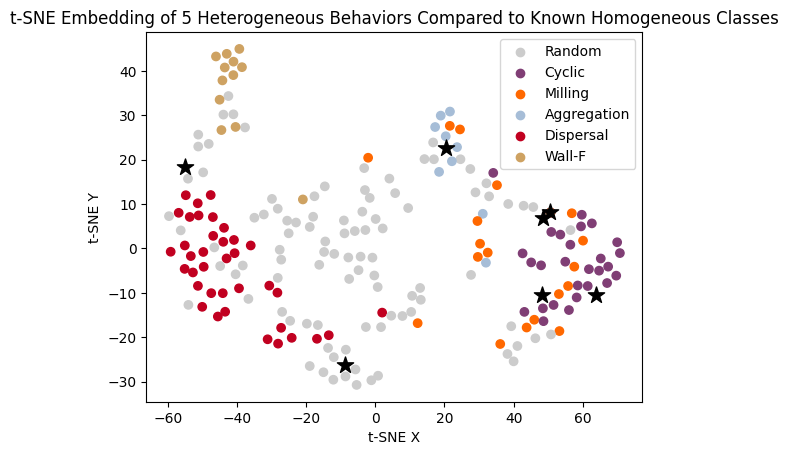

In [5]:
"""
Visualize (MatPlotLib)
"""
lim = len(homogeneous_archive.archive)
x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]
plt.scatter(x, y, c=homogeneous_colors, cmap="rgb", marker="o")

x = [reduced[i][0] for i in range(lim, len(reduced))]
y = [reduced[i][1] for i in range(lim, len(reduced))]

# Add Legend Labels (Hacky)
for i in range(len(classes)):
    plt.scatter(x[0], y[0], c=list(labels.color_map.values())[i], label=classes[i])

for i, m in zip(range(len(x)), ["*", "^", ">", "<", "s", "v", "o"]):
    # plt.scatter(x[i], y[i], c=heterogeneous_colors[i], cmap="rgb", marker=m, s=150)
    plt.scatter(x[i], y[i], c=heterogeneous_colors[i], cmap="rgb", marker="*", s=150)



plt.title("t-SNE Embedding of 5 Heterogeneous Behaviors Compared to Known Homogeneous Classes")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.legend()
plt.show()